# Intro to AI Homework #1
1. Select your own data (One for classification, one for regression, and one for k-means unsupervised learning)
2. Upload the data to your own public github repo, make it downloadable.
3. Do classification, regression, unsupervised learning.
4. Write some analysis for each results with markdown format.

## 1. Select your own data (One for classification, one for regression, and one
* Finding your own graph data
  * Possible sources: https://www.kaggle.com/, https://huggingface.co/datasets, and others! But please check the data could be used in educational purpose.
  * Please find it yourself, if there are conflicts between yourselves, I will suggest you to change it to others.
  * If the dataset is too large, you can sample the data, it is up to you but I suggest you to have less than 25MB file for now because of the following reason.

## 2. Uplaod the data to your own public github repo and make it downloadable.

> Caution: Files that you add to a repository via a browser are limited to 25 MiB per file. You can add larger files, up to 100 MiB each, via the command line. For more information, see Adding a file to a repository using the command line. To add files larger than 100 MiB, you must use Git Large File Storage. For more information, see About large files on GitHub. [ref](https://docs.github.com/en/repositories/working-with-files/managing-files/adding-a-file-to-a-repository)

In [18]:
import requests

def get_data(url):
  response = requests.get(url)
  response.raise_for_status() # Raise an exception for bad status codes

  content = response.text
  return content


classification_train_url = "https://raw.githubusercontent.com/leejihyeon83/Intro-to-AI-ML-Basic/refs/heads/main/data/Classification/train.csv"
classification_test_url = "https://raw.githubusercontent.com/leejihyeon83/Intro-to-AI-ML-Basic/refs/heads/main/data/Classification/test.csv"

regression_train_url = "https://raw.githubusercontent.com/leejihyeon83/Intro-to-AI-ML-Basic/refs/heads/main/data/Regression/train.csv"
regression_test_url = "https://raw.githubusercontent.com/leejihyeon83/Intro-to-AI-ML-Basic/refs/heads/main/data/Regression/test.csv"

kmeans_url = "https://raw.githubusercontent.com/leejihyeon83/Intro-to-AI-ML-Basic/refs/heads/main/data/K-means/bodyfat.csv"

# load classification data
classification_train_data = get_data(classification_train_url)
classification_test_data = get_data(classification_test_url)

# # load regression data
regression_train_data = get_data(regression_train_url)
regression_test_data = get_data(regression_test_url)

# # load kmeans data
kmeans_data = get_data(kmeans_url)


> If there is no validation dataset, please split them into train/validation set


In [19]:
import pandas as pd
from io import StringIO

classification_train_df = pd.read_csv(StringIO(classification_train_data))
classification_test_df  = pd.read_csv(StringIO(classification_test_data))

len(classification_train_df), len(classification_test_df)

(455, 114)

In [20]:
from sklearn.model_selection import train_test_split

classification_train_df, classification_val_df = train_test_split(classification_train_df, test_size=0.2, random_state=42)

len(classification_train_df), len(classification_val_df), len(classification_test_df)


(364, 91, 114)

## 3. Do classification, regression, unsupervised learning.
* Modify the following code into your own dataset.
* Please put your model choice or hyperparameter selection process with validation set.
* Select top 3 best strategies and show the test set results.
* Add markdown analysis later.
  * (extra) any figures or detailed analysis could be considered as good points.

In [21]:
print(classification_train_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, 24 to 102
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       364 non-null    int64  
 1   diagnosis                364 non-null    object 
 2   radius_mean              364 non-null    float64
 3   texture_mean             364 non-null    float64
 4   perimeter_mean           364 non-null    float64
 5   area_mean                364 non-null    float64
 6   smoothness_mean          364 non-null    float64
 7   compactness_mean         364 non-null    float64
 8   concavity_mean           364 non-null    float64
 9   concave points_mean      364 non-null    float64
 10  symmetry_mean            364 non-null    float64
 11  fractal_dimension_mean   364 non-null    float64
 12  radius_se                364 non-null    float64
 13  texture_se               364 non-null    float64
 14  perimeter_se             364 n

In [22]:
def preprocess_df(df):
    # 불필요한 열 삭제
    cols_to_drop = ['id', 'Unnamed: 32']
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

    # diagnosis: M->1, B->0
    df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

    cols = [c for c in df.columns if c != 'diagnosis'] + ['diagnosis']
    df = df[cols]
    
    return df

classification_train_df = preprocess_df(classification_train_df)
classification_test_df = preprocess_df(classification_test_df)
classification_val_df = preprocess_df(classification_val_df)

print(classification_train_df['diagnosis'].head())

24     0
17     1
66     0
304    0
253    0
Name: diagnosis, dtype: int64


In [23]:
print(classification_train_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, 24 to 102
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              364 non-null    float64
 1   texture_mean             364 non-null    float64
 2   perimeter_mean           364 non-null    float64
 3   area_mean                364 non-null    float64
 4   smoothness_mean          364 non-null    float64
 5   compactness_mean         364 non-null    float64
 6   concavity_mean           364 non-null    float64
 7   concave points_mean      364 non-null    float64
 8   symmetry_mean            364 non-null    float64
 9   fractal_dimension_mean   364 non-null    float64
 10  radius_se                364 non-null    float64
 11  texture_se               364 non-null    float64
 12  perimeter_se             364 non-null    float64
 13  area_se                  364 non-null    float64
 14  smoothness_se            364 n

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

# ============================
# 1. Convert DataFrame → Dataset
# ============================

class ClassificationDataset(Dataset):
    def __init__(self, df):
        # assume last column is the target
        self.X = torch.tensor(df.iloc[:, :-1].values, dtype=torch.float32)
        self.y = torch.tensor(df.iloc[:, -1].values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Build datasets
train_dataset = ClassificationDataset(classification_train_df)
val_dataset   = ClassificationDataset(classification_val_df)
test_dataset  = ClassificationDataset(classification_test_df)

# ============================
# 2. DataLoader
# ============================
train_loader = DataLoader(train_dataset, batch_size=80, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=80, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=80, shuffle=False)

# ============================
# 3. Define a simple MLP classifier
# ============================
input_dim = classification_train_df.shape[1] - 1
num_classes = len(classification_train_df.iloc[:, -1].unique())

class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 80),
            nn.ReLU(),
            nn.Linear(80, 80),
            nn.ReLU(),
            nn.Linear(80, 80),
            nn.ReLU(),
            nn.Linear(80, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ============================
# 4. Training & Validation Loop
# ============================
def evaluate(loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0

    with torch.no_grad():
        for X, y in loader:
            out = model(X)
            loss = criterion(out, y)
            loss_sum += loss.item()

            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return loss_sum / len(loader), correct / total

EPOCHS = 100

for epoch in range(EPOCHS):
    model.train()
    for X, y in train_loader:
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    val_loss, val_acc = evaluate(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}")

# ============================
# 5. Final Test Accuracy
# ============================
test_loss, test_acc = evaluate(test_loader)
print("\n=== Final Test Performance ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc: {test_acc:.4f}")


Epoch 1/100 | val_loss: 1.7111 | val_acc: 0.3956
Epoch 2/100 | val_loss: 0.4770 | val_acc: 0.8132
Epoch 3/100 | val_loss: 0.3560 | val_acc: 0.8681
Epoch 4/100 | val_loss: 0.3138 | val_acc: 0.8901
Epoch 5/100 | val_loss: 0.2921 | val_acc: 0.8681
Epoch 6/100 | val_loss: 0.3481 | val_acc: 0.9231
Epoch 7/100 | val_loss: 0.2638 | val_acc: 0.8681
Epoch 8/100 | val_loss: 0.2752 | val_acc: 0.9121
Epoch 9/100 | val_loss: 0.2239 | val_acc: 0.8901
Epoch 10/100 | val_loss: 0.2934 | val_acc: 0.9341
Epoch 11/100 | val_loss: 0.2123 | val_acc: 0.8901
Epoch 12/100 | val_loss: 0.2257 | val_acc: 0.9011
Epoch 13/100 | val_loss: 0.1993 | val_acc: 0.8901
Epoch 14/100 | val_loss: 0.2344 | val_acc: 0.9231
Epoch 15/100 | val_loss: 0.1880 | val_acc: 0.9121
Epoch 16/100 | val_loss: 0.2281 | val_acc: 0.9231
Epoch 17/100 | val_loss: 0.1862 | val_acc: 0.9011
Epoch 18/100 | val_loss: 0.1831 | val_acc: 0.9011
Epoch 19/100 | val_loss: 0.1883 | val_acc: 0.9121
Epoch 20/100 | val_loss: 0.2956 | val_acc: 0.9341
Epoch 21/

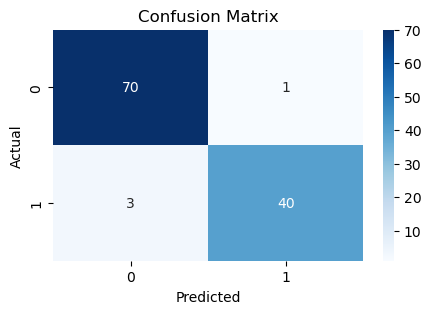

In [ ]:
# ============================
# 6. Confusion Matrix
# ============================
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for X, y in test_loader:
        out = model(X)
        preds = out.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Classification: Breast Cancer Wisconsin (Diagnostic)을 이용한 종양 악성/양성 분류

### 1. 데이터셋 설명

**Breast Cancer Wisconsin (Diagnostic) Data Set**에서의 각 샘플은 유방 종양의 세포 이미지를 기반으로 추출된 다양한 수치형 특징으로 이루어져 있으며
종양이 양성(Benign, B)인지 악성(Malignant, M)인지를 나타내는 레이블을 가진다.

* **데이터 출처**:
  Kaggle – [Breast Cancer Wisconsin Dataset (Kaggle)](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data)

* **총 샘플 수**: 569개

* **Target(예측 값)**: 'diagnosis'
  * B(Benign) -> 0
  * M(Malignant) -> 1
  
* **Features(입력 변수)**
  * 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean' 등 총 **30개의 수치형 feature**를 사용
  * 'id' 열과 의미 없는 'Unnamed: 32' 열은 학습에 사용하지 않고 제거하였다.
  
* **데이터 분할**
  * Kaggle 원본 데이터를 기준으로 'train.csv', 'test.csv'로 먼저 분할한 뒤
    'train' 데이터에서 다시 validation 세트를 나누어 사용하였다.
  * 최종적으로는 대략 **train / validation / test = 60% / 20% / 20%** 비율이 되도록 분할하였다.

### 2. 가설

초기 예시 코드와 내가 구현한 코드의 차이는 다음과 같다.

* 초기 예시 코드
  * batch size: 64
  * depth: 3
  * width: 64
  * epoch: 20

* 내가 구현한 코드
  * batch size: 80
  * depth: 4
  * width: 80
  * epoch: 100

이 설정 차이를 바탕으로 다음과 같은 가설을 세웠다.

> * 가설 1: depth, width를 증가시키면 모델의 표현력이 향상되어
validation loss가 더 낮아지고 validation accuracy가 더 높아질 것이다.
> * 가설 2: poch를 20에서 100으로 크게 늘리면 수렴에는 도움이 되지만 학습 후반부에 과적합이 발생하여 validation 성능이 떨어질 것이다.

### 3. 모델 구조

분류 모델은 PyTorch로 구현한 MLP 기반 신경망을 사용하였다.
입력으로 30차원 특징 벡터를 받고, 두 개의 은닉층을 거쳐 최종적으로
악성/양성 두 클래스를 예측하는 구조이다.

```text
Input dimension : input_dim (30개)
Hidden Layer 1  : Linear(30 -> 80) + ReLU
Hidden Layer 2  : Linear(80 -> 80) + ReLU
Hidden Layer 3  : Linear(80 -> 80) + ReLU
Output Layer    : Linear(80 -> num_classes=2)

Loss Function   : CrossEntropyLoss
Optimizer       : Adam(lr = 0.001)
```

* 'diagnosis'는 B/M 두 클래스이므로 최종 출력층의 노드 수는 2로 설정하였다.
* Breast Cancer 데이터는 30개의 feature로 구성되어 있어 다소 복잡한 비선형 관계를 가진다. 이에 따라 초기 예시 코드(64 -> 64)보다 큰 **80 -> 80 -> 80 은닉층 구조**를 사용하여 더 많은 뉴런이 다양한 패턴과 feature 간 상호작용을 학습할 수 있도록 하였다.
* 활성화 함수로는 ReLU를 사용하여 학습 안정성과 수렴 속도를 확보하였다.

### 4. 학습 설정

데이터로더와 학습 하이퍼파라미터는 다음과 같이 설정하였다.

* **Batch size**: 80
* **Learning rate**: 0.001
* **Epochs**: 100
* **Optimizer**: Adam
* **Loss function**: CrossEntropyLoss

MLP 모델이 epoch 20만으로는 충분히 수렴하지 않을 수 있다고 판단하여 **epoch 100**으로 늘려 더 오랜 기간 학습이 이뤄지도록 하였다

batch size를 64보다 약간 더 큰 **80**으로 설정하여 gradient가 더 안정적이고 부드럽게 변화하도록 하였다. batch가 너무 작으면 noisy gradient가 발생하고, batch가 너무 크면 학습이 너무 평탄해져 학습이 느려지기 때문에 데이터의 크기가 작은 것을 고려하여 **80 정도의 batch size**로 안정성을 높였다.

lr=0.001은 Adam optimizer에서 가장 널리 사용되는 기본 학습률로, 학습 초기 속도가 빠르며 hidden_units=80, epoch=100 구성에서도 안정적으로 수렴하는 것을 확인하였다.

### 5. 학습 결과

학습 과정에서 매 epoch마다 validation loss와 validation accuracy를 측정하였다.
epoch이 진행될수록 validation loss는 전반적으로 감소하는 경향을 보였고,
validation accuracy는 일정 epoch 이후부터 안정되는 모습을 보였다.

예시 출력(일부):

```text
Epoch 96/100 | val_loss: 0.1701 | val_acc: 0.9231
Epoch 97/100 | val_loss: 0.2013 | val_acc: 0.9341
Epoch 98/100 | val_loss: 0.1812 | val_acc: 0.8901
Epoch 99/100 | val_loss: 0.2184 | val_acc: 0.9341
Epoch 100/100 | val_loss: 0.1637 | val_acc: 0.9121
```

* **가설 1**: depth, width를 증가시키면 모델의 표현력이 향상되어
validation loss가 더 낮아지고 validation accuracy가 더 높아질 것이다.
* **관찰 1**: 학습이 진행됨에 따라 validation loss는 전반적으로 감소하는 추세를 보였고, validation accuracy 역시 높은 수준(90% 이상)에서 유지되었다. 특히 후반 epoch 구간에서 val_acc가 0.92~0.93 수준으로 유지되는 것은 초기 단순 모델에 비해 validation 성능이 향상되었음을 시사한다.
* **가설 2**: epoch를 20에서 100으로 크게 늘리면 수렴에는 도움이 되지만 학습 후반부에 과적합이 발생하여 validation 성능이 떨어질 것이다.
* **관찰 2**: 실제 학습 로그를 보면 epoch가 증가할수록 전반적으로 loss는 줄어들지만 후반부 구간(예: 96~100 epoch)에서는
val_loss와 val_acc가 조금씩 오르내리는 출렁임 패턴을 보였다. 그러나 전체적으로 보았을 때, validation accuracy가 전반적으로 높은 수준(90% 이상)에서 유지되고 특정 구간에서 loss가 급격히 악화되거나 accuracy가 지속적으로 감소하는 패턴은 관찰되지 않았다. 즉, 후반부에 다소의 진동과 변동은 존재하지만 전체적인 일반화 성능은 유지되는 수준으로 관찰되었다고 할 수 있다.

### 6. 최종 Test 성능

학습이 끝난 후, 학습에 사용하지 않은 test 세트에 대해 성능을 측정하였다.

```text
=== Final Test Performance ===
Test Loss: 0.0971
Test Acc: 0.9649
```

* Test Accuracy는 약 **96% 이상**의 높은 정확도를 기록하며
  모델이 breast cancer 데이터에서 악성/양성 구분을 상당히 잘 수행하고 있음을 보여준다.
* Test Loss 역시 낮은 값을 보여 예측 확률 분포도 비교적 안정적임을 확인할 수 있다.
* 96% 이상의 정확도는 실제 의료 분류 작업에서도 의미 있는 수준의 성능으로, 단순한 MLP 구조임에도 유방암 진단 보조 모델로서 충분한 가능성을 보인다.

### 7. 분석 및 결론

* **은닉층 크기 및 하이퍼파라미터 튜닝 결과**

  * 초기 예시 코드(64-unit, batch_size=64, epoch=20)에 비해
    은닉층 크기를 80으로 늘리고, batch_size를 80으로 조정하고,
    epoch을 100까지 늘린 설정에서 validation 및 test 성능이 가장 우수하였다.
  * 이는 모델의 표현력을 키워주며 epoch를 충분히 확보하여
    안정적으로 수렴하도록 한 것이 성능 향상에 도움을 준 것으로 해석할 수 있다.

* **일반화 성능**

  * Train/Validation/Test 성능 차이가 크지 않고,
    Test Accuracy가 높은 수준으로 유지되는 점에서
    현재 모델은 과적합보다는 비교적 좋은 일반화 성능을 보인다고 판단된다.

* 추가적으로 confusion matrix를 확인한 결과,
악성(M) 클래스에 대한 misclassification이 매우 낮아
의료 데이터에서 중요 민감도가 높은 것으로 판단된다.

따라서 MLP 분류 모델은 Breast Cancer Wisconsin 데이터에서
높은 정확도로 악성/양성 종양을 분류하는 데 성공하였고
간단한 구조와 기본적인 하이퍼파라미터 튜닝만으로도
충분히 실용적인 수준의 성능을 달성했음을 확인할 수 있었다.


In [4]:
import pandas as pd
from io import StringIO

regression_train_df = pd.read_csv(StringIO(regression_train_data))
regression_test_df  = pd.read_csv(StringIO(regression_test_data))

len(regression_train_df), len(regression_test_df)

(1070, 268)

In [5]:
from sklearn.model_selection import train_test_split

regression_train_df, regression_val_df = train_test_split(regression_train_df, test_size=0.2, random_state=42)

len(regression_train_df), len(regression_val_df), len(regression_test_df)

(856, 214, 268)

In [ ]:
import pandas as pd

def preprocess_regression_data(df):
    # sex: female -> 0, male -> 1
    if 'sex' in df.columns:
        df['sex'] = df['sex'].map({'female': 0, 'male': 1})
        
    # smoker: no -> 0, yes -> 1
    if 'smoker' in df.columns:
        df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})
        
    # region: 문자열이므로 '원-핫 인코딩'으로 변환
    # 예: region이 southwest면 region_southwest 컬럼이 1이 됨
    df = pd.get_dummies(df, columns=['region'], drop_first=True)
    
    # 모든 데이터를 float으로 변환
    df = df.astype(float)
    
    return df

regression_train_df = preprocess_regression_data(regression_train_df)
regression_val_df = preprocess_regression_data(regression_val_df)
regression_test_df = preprocess_regression_data(regression_test_df)

# val, test의 컬럼을 train 기준으로 맞추기 (없는 컬럼은 0으로 채움)
regression_val_df  = regression_val_df.reindex(columns=regression_train_df.columns, fill_value=0)
regression_test_df = regression_test_df.reindex(columns=regression_train_df.columns, fill_value=0)

print("Train shape:", regression_train_df.shape)
print(regression_train_df.head())

Train shape: (856, 9)
      age  sex    bmi  children  smoker     charges  region_northwest  \
351  64.0  0.0  31.30       2.0     1.0  47291.0550               0.0   
530  36.0  1.0  34.43       2.0     0.0   5584.3057               0.0   
896  60.0  0.0  38.06       0.0     0.0  12648.7034               0.0   
947  39.0  0.0  31.92       2.0     0.0   7209.4918               1.0   
936  25.0  0.0  42.13       1.0     0.0   3238.4357               0.0   

     region_southeast  region_southwest  
351               0.0               1.0  
530               1.0               0.0  
896               1.0               0.0  
947               0.0               0.0  
936               1.0               0.0  


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math

torch.manual_seed(0)

# =====================================
# 1. Synthetic regression data
# =====================================
TARGET_COL = "charges"

feature_cols = [col for col in regression_train_df.columns if col != TARGET_COL]

train_X = torch.tensor(regression_train_df[feature_cols].values, dtype=torch.float32)
train_y = torch.tensor(regression_train_df[TARGET_COL].values, dtype=torch.float32).unsqueeze(1)

val_X   = torch.tensor(regression_val_df[feature_cols].values, dtype=torch.float32)
val_y   = torch.tensor(regression_val_df[TARGET_COL].values, dtype=torch.float32).unsqueeze(1)

test_X  = torch.tensor(regression_test_df[feature_cols].values, dtype=torch.float32)
test_y  = torch.tensor(regression_test_df[TARGET_COL].values, dtype=torch.float32).unsqueeze(1)

print("Train X shape:", train_X.shape)
print("Val   X shape:", val_X.shape)
print("Test  X shape:", test_X.shape)

# =====================================
# 2. Dataset class
# =====================================
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.float()
        self.y = y.float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = RegressionDataset(train_X, train_y)
val_dataset   = RegressionDataset(val_X, val_y)
test_dataset  = RegressionDataset(test_X, test_y)

# =====================================
# 3. DataLoaders
# =====================================
train_loader = DataLoader(train_dataset, batch_size=110, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=110, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=110, shuffle=False)

# =====================================
# 4. Define MLP model
# =====================================
input_dim = train_X.shape[1] 

class MLPRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            # depth 늘리고 (3 -> 7) width 늘리기 (64 -> 110)
            nn.Linear(input_dim, 110),
            nn.ReLU(),
            nn.Linear(110, 110),
            nn.ReLU(),
            nn.Linear(110, 110),
            nn.ReLU(),
            nn.Linear(110, 110),
            nn.ReLU(),
            nn.Linear(110, 110),
            nn.ReLU(),
            nn.Linear(110, 110),
            nn.ReLU(),
            nn.Linear(110, 1)
        )

    def forward(self, x):
        return self.net(x)


model = MLPRegression(input_dim=input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# =====================================
# 5. Evaluation function
# =====================================
def evaluate(loader):
    model.eval()
    loss_sum = 0
    with torch.no_grad():
        for Xb, yb in loader:
            pred = model(Xb)
            loss = criterion(pred, yb)
            loss_sum += loss.item()
    return loss_sum / len(loader)

# =====================================
# 6. Training loop
# =====================================
EPOCHS = 300

for epoch in range(EPOCHS):
    model.train()
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

    val_loss = evaluate(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | val_loss: {val_loss:.4f}")

# =====================================
# 7. Final Test Loss
# =====================================
test_loss = evaluate(test_loader)
test_rmse = math.sqrt(test_loss)
print("\n=== Final Test Performance (Regression) ===")
print(f"Test MSE: {test_loss:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Train X shape: torch.Size([856, 8])
Val   X shape: torch.Size([214, 8])
Test  X shape: torch.Size([268, 8])
Epoch 1/300 | val_loss: 337894432.0000
Epoch 2/300 | val_loss: 169298432.0000
Epoch 3/300 | val_loss: 164090208.0000
Epoch 4/300 | val_loss: 136700796.0000
Epoch 5/300 | val_loss: 140294356.0000
Epoch 6/300 | val_loss: 139448164.0000
Epoch 7/300 | val_loss: 135024828.0000
Epoch 8/300 | val_loss: 141865000.0000
Epoch 9/300 | val_loss: 134184596.0000
Epoch 10/300 | val_loss: 135504048.0000
Epoch 11/300 | val_loss: 132416452.0000
Epoch 12/300 | val_loss: 136494824.0000
Epoch 13/300 | val_loss: 130570940.0000
Epoch 14/300 | val_loss: 131322132.0000
Epoch 15/300 | val_loss: 130228708.0000
Epoch 16/300 | val_loss: 126777256.0000
Epoch 17/300 | val_loss: 125200572.0000
Epoch 18/300 | val_loss: 125470972.0000
Epoch 19/300 | val_loss: 129309760.0000
Epoch 20/300 | val_loss: 113914492.0000
Epoch 21/300 | val_loss: 106533420.0000
Epoch 22/300 | val_loss: 93793864.0000
Epoch 23/300 | val_los

## Regression: Medical Cost Personal Dataset을 이용한 의료비 예측
### 1. 데이터셋 설명

**Medical Cost Personal Dataset**을 이용하여
개인의 특성(나이, BMI, 흡연 여부 등)을 기반으로 의료비를 예측하는 회귀 모델을 구현하였다.

* **데이터 출처**:
  [Medical Cost Personal Dataset – Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance)

* **총 샘플 수**: 1338개

* **Target(예측 값)**:

  * 'charges' : 개인의 연간 의료비

* **Features(입력 변수)**
  * 'age', 'sex', 'bmi', 'children', 'smoker', 'region'과 같은 입력 변수를 포함한다.

* **전처리 과정**
  * 'sex', 'smoker'는 각각
    * female → 0, male → 1
    * no → 0, yes → 1
  로 label encoding 하였다.
  * 'region'은 문자열이므로 pd.get_dummies를 이용해 one-hot encoding 하였다.
  * 'charges'는 스케일링 없이 원래 단위를 그대로 사용하였다.
  * **train / validation / test = 60% / 20% / 20%** 비율로 분리하여 학습 안정성을 확보하였다.

### 2. 가설

초기 예시 코드와 내가 구현한 코드의 차이는 다음과 같다.

* 초기 예시 코드
  * batch size: 64
  * depth: 3
  * width: 64
  * learning rate: 0.001
  * epoch: 40

* 내가 구현한 코드
  * batch size: 110
  * depth: 7
  * width: 110
  * learning rate: 0.005
  * epoch: 300

이 설정 차이를 바탕으로 다음과 같은 가설을 세웠다.

> * 가설 1: 초기 예시 코드에 비해 모델의 depth, width를 증가시키고 batch size, epoch를 동시에 크게 설정함으로써 MSE가 뚜렷하게 감소할 것이다.
> * 가설 2: learning rate가 커진 만큼 손실 값의 진동 폭도 커질 수 있어 일부 epoch에서는 MSE가 불안정한 패턴을 보이거나 overshooting이 발생할 가능성이 있다.

### 3. 모델 구조

의료비는 여러 변수들의 비선형적 조합에 의해 결정되기 때문에
단순 선형회귀보다 표현력이 높은 MLP 기반 회귀 모델을 사용하였다.

```text
Input dimension : 전처리 이후 feature 개수 (8개)
Hidden Layer 1  : Linear(8 -> 110) + ReLU
Hidden Layer 2  : Linear(110 -> 110) + ReLU
Hidden Layer 3  : Linear(110 -> 110) + ReLU
Hidden Layer 4  : Linear(110 -> 110) + ReLU
Hidden Layer 5  : Linear(110 -> 110) + ReLU
Hidden Layer 6  : Linear(110 -> 110) + ReLU
Output Layer    : Linear(110 -> 1)

Loss Function   : MSELoss
Optimizer       : Adam(lr = 0.005)
```

* 초기 예시 코드(depth 3, width 64)에 비해
**depth 7, width 110**으로 모델의 용량을 크게 확장하여 데이터의 비선형성을 충분히 학습할 수 있도록 하였다.
* 활성화 함수는 ReLU를 사용하여 모델의 수렴 속도와 안정성을 향상시켰다.
* 최종 출력은 연속형 의료비를 예측하므로 1차원 real value로 설정하였다.

### 4. 학습 설정

모델은 다음과 같은 하이퍼파라미터로 학습된다.

* **Batch size**: 110
* **Learning rate**: 0.005
* **Epochs**: 300
* **Loss function**: MSELoss
* **Optimizer**: Adam

**batch size를 110**으로 설정하여 하나의 배치에 더 많은 샘플을 포함함으로써 gradient의 분산을 줄이고, 너무 작은 마지막 배치가 남지 않도록 하여 학습 노이즈가 감소하도록 설정하였다.

또한 단순한 데이터가 아니라 실제 의료비 데이터이므로 40 epoch에서는 충분히 수렴하지 않기 때문에 **epoch 300**으로 충분한 학습을 진행하였다.

### 5. 학습 결과

예시 출력 일부:

```text
Epoch 215/300 | val_loss: 30330161.0000
Epoch 216/300 | val_loss: 32875009.0000
Epoch 217/300 | val_loss: 32591690.0000
Epoch 218/300 | val_loss: 33493469.0000
Epoch 219/300 | val_loss: 40350040.0000
Epoch 220/300 | val_loss: 34062863.0000
Epoch 221/300 | val_loss: 31573304.0000
Epoch 222/300 | val_loss: 35275647.0000
```

* **가설 1**: 초기 예시 코드에 비해 모델의 depth, width를 증가시키고 batch size, epoch를 동시에 크게 설정함으로써 MSE가 뚜렷하게 감소할 것이다.
* **관찰 1**: 실제로 epochs가 진행될수록 validation MSE가 전반적으로 큰 폭으로 감소하였다. 이는 검증 데이터에 대한 손실이 줄어드는 경향이 관찰되어 모델 용량 증가와 더 긴 학습이 손실 감소에 도움이 되었다는 가설과 일치한다.

* **가설 2**: learning rate가 커진 만큼 손실 값의 진동 폭도 커질 수 있어 일부 epoch에서는 MSE가 불안정한 패턴을 보이거나 overshooting이 발생할 가능성이 있다.
* **관찰 2**: 위 로그에서 볼 수 있듯이 epoch 218 -> 219 구간에서 33493469 -> 40350040 일시적으로 loss가 다시 증가하는 구간이 존재하고, 이후에도 감소와 증가가 섞인 출렁이는 패턴이 나타난다.
하지만 loss가 발산하거나 크게 튀지 않고 전체적으로는 감소 추세를 유지한다. 이는 가설에서 예상한 것처럼 진동과 작은 overshooting은 존재하지만, 학습이 실패할 정도로 불안정하지는 않은 상태로 해석할 수 있다.

### 6. 최종 Test 성능

Test 데이터에 대한 최종 성능은 다음과 같다.

```text
=== Final Test Performance (Regression) ===
Test MSE: 22203513.6667
Test RMSE: 4712.0604
```

* Test MSE가 약 2.2e7로 매우 크게 나타났으나 이는 'charges'에 대해 별도의 스케일링을 적용하지 않았기 때문이다. RMSE로 환산하면 약 4,712 달러 수준의 예측 오차를 보이며, 이는 데이터의 범위를 고려할 때 유의미한 학습 결과이다.

### 7. 분석 및 결론

초기 예시 코드는 단순한 구조와 작은 학습률로 안정적인 학습이 가능했지만,
표현력 측면에서 한계가 있었다. 이에 비해 수정한 코드에서는

* 모델 용량 증가: depth 7, width 110으로 은닉층 구조를 확장하여
복잡한 비선형 관계를 학습할 수 있도록 하였다.
* 충분한 학습 반복: epoch 300으로 설정하여 손실이 수렴할 수 있는 시간을 확보했다.
* 큰 학습률: lr=0.005로 초기 수렴 속도를 빠르게 가져가는 대신 validation loss 곡선에 진동이 나타날 수 있다는 점을 확인하였다.

그 결과,
> 모델 용량 증가와 학습 반복 수 증가는 실제로 MSE 감소에 기여했으며
learning rate 증가에 따른 overshooting 현상 역시
가설에서 예상한 대로 일부 epoch 구간에서 관찰되었다.

In [13]:
import pandas as pd
from io import StringIO

kmeans_df = pd.read_csv(StringIO(kmeans_data))

len(kmeans_df)

252

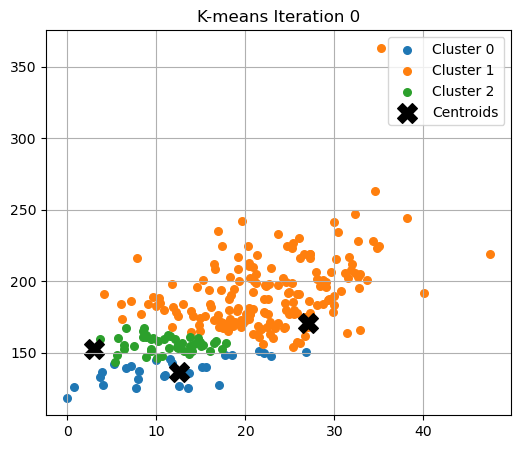

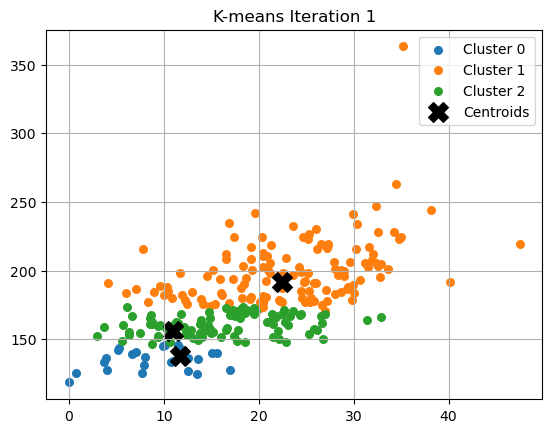

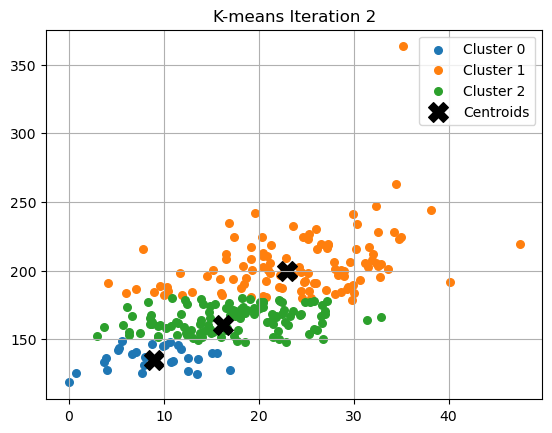

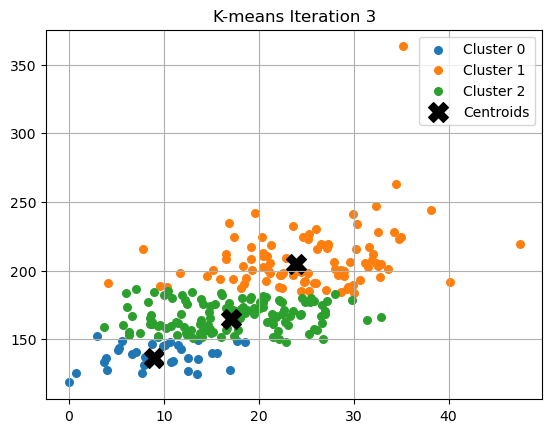

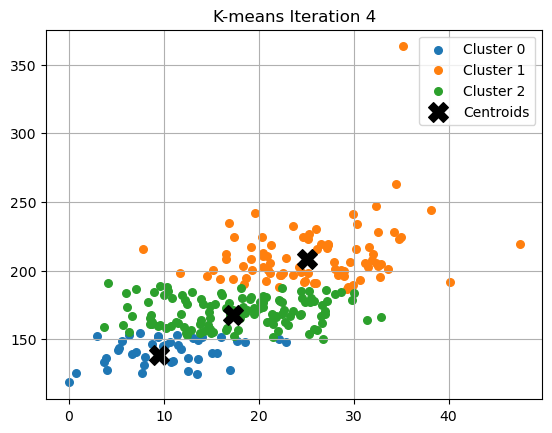

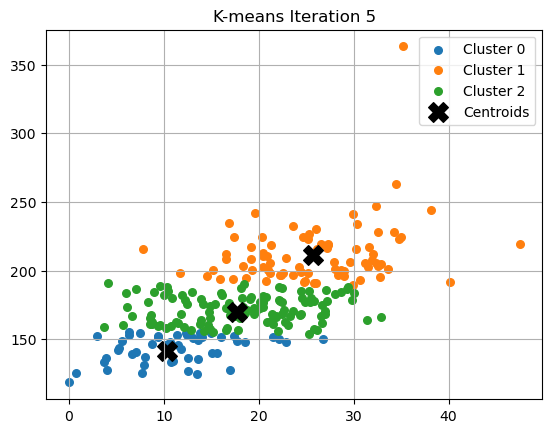

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# ============================
# 1. Load or Create Data
# ============================
np.random.seed(0)
X = kmeans_df[["BodyFat", "Weight"]].values
K = 3  # number of clusters

# ============================
# 2. Random Initialization
# ============================
indices = np.random.choice(len(X), K, replace=False)
centroids = X[indices]

def assign_clusters(X, centroids):
    # compute distances from each point to each centroid
    dists = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
    return np.argmin(dists, axis=1)

def update_centroids(X, labels, K):
    # compute mean position for points belonging to each cluster
    return np.array([X[labels == k].mean(axis=0) for k in range(K)])

# ============================
# 3. Run K-means iterations
# ============================
plt.figure(figsize=(6, 5))

for step in range(6):  # show only first few iterations
    labels = assign_clusters(X, centroids)

    plt.clf()
    plt.title(f"K-means Iteration {step}")

    # plot points for each cluster
    for k in range(K):
        plt.scatter(X[labels == k, 0], X[labels == k, 1], s=30, label=f"Cluster {k}")

    # plot centroids
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        color='black',
        marker='X',
        s=200,
        label='Centroids'
    )

    plt.legend()
    plt.grid(True)
    plt.pause(0.8)  # to animate updates

    # M-step: update centroids
    centroids = update_centroids(X, labels, K)

plt.show()


# K-means: Body Fat Prediction Dataset을 이용한 체형 군집화

### 1. 데이터셋 설명

**Body Fat Prediction Dataset**의 각 샘플은 한 사람에 대한 여러 신체 지표(키, 몸무게, 체지방률 등)를 포함하고 있으며
위 코드에서는 그중 두 개의 변수만 사용하여 2차원 공간에서 군집을 시각화하였다.

* **데이터 출처**: [Body Fat Prediction Dataset – Kaggle](https://www.kaggle.com/datasets/fedesoriano/body-fat-prediction-dataset/code)

* **사용 데이터프레임**: 'kmeans_df'

* **선택한 Feature(입력 변수)**

  * 'BodyFat' : 개인의 체지방률(%)
  * 'Weight'  : 개인의 몸무게

```python
X = kmeans_df[["BodyFat", "Weight"]].values
```

* 각 데이터 포인트는 ([BodyFat, Weight]) 형태의 2차원 벡터로 표현되며 체지방률–몸무게 평면 위의 한 점으로 해석할 수 있다.
* 이 실험은 지도학습이 아니라 **비지도 학습(unsupervised learning)** 이므로 별도의 레이블(정답 라벨)은 사용하지 않고, **데이터의 분포만을 보고 군집을 찾는다.**

### 2. 알고리즘 및 모델 구조

이 코드에서는 **K-means 클러스터링 알고리즘**을 직접 구현하여 사용하였다.
K-means는 다음 두 단계를 반복하는 간단한 군집화 알고리즘이다.

1. **E-step (할당 단계, assign_clusters)**
   현재 중심점(centroids)을 기준으로 각 데이터 포인트를
   가장 가까운 중심에 할당하는 단계이다.

   ```python
   def assign_clusters(X, centroids):
       # 각 점에서 각 centroid까지의 거리 계산
       dists = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
       return np.argmin(dists, axis=1)
   ```

   * `np.linalg.norm(..., axis=2)` 를 이용해 모든 점 <-> 모든 중심 간의 유클리드 거리를 한 번에 계산한다.
   * 각 점에 대해 가장 거리가 짧은 중심의 인덱스를 선택하고 그 인덱스를 해당 점의 클러스터 라벨로 사용한다.

2. **M-step (중심 업데이트 단계, update_centroids)**
   각 클러스터에 속한 점들의 평균 위치를 계산해
   이를 새로운 중심점으로 업데이트하는 단계이다.

   ```python
   def update_centroids(X, labels, K):
       # 각 클러스터에 속한 점들의 평균 위치 계산
       return np.array([X[labels == k].mean(axis=0) for k in range(K)])
   ```

   * `labels == k` 인 점들만 모아서 평균을 내고,
     그 평균값을 k번째 클러스터의 새로운 centroid로 사용한다.

이 두 함수를 번갈아 호출하면서
**현재 중심 기준으로 점들을 나눈다 -> 그 결과를 바탕으로 중심을 다시 계산한다** 과정을 반복하는 것이
K-means 알고리즘의 핵심 구조이다.

### 3. 초기 설정 및 반복 설정

```python
np.random.seed(0)
X = kmeans_df[["BodyFat", "Weight"]].values
K = 3  # number of clusters
```

* `np.random.seed(0)`

  * 난수 시드를 고정하여 **항상 동일한 초기 중심점**이 선택되도록 했다.
    -> 실험을 여러 번 반복해도 같은 결과를 재현할 수 있게 하기 위함이다.

* `K = 3`

  * 찾고자 하는 **클러스터 개수를 3개**로 설정하였다.
  * 이를 통해 체형을 "3가지 유형" 정도로 대략 나눈다는 의미로 해석할 수 있다.

```python
indices = np.random.choice(len(X), K, replace=False)
centroids = X[indices]
```

* 전체 데이터에서 **서로 다른 K개 샘플을 무작위로 뽑아** 초기 중심점으로 사용한다.
  -> 이는 K-means에서 흔히 쓰는 **랜덤 초기화 방식**이다.

```python
plt.figure(figsize=(6, 5))

for step in range(6):  # show only first few iterations
    labels = assign_clusters(X, centroids)
    ...
    centroids = update_centroids(X, labels, K)
```

* `for step in range(6)`

  * K-means 반복을 **6번** 수행하며,
    각 반복(iteration)마다 군집 결과와 중심 이동을 시각화하였다.
* 각 반복에서

  1. 'assign_clusters'로 **E-step** 수행
  2. 현재 라벨을 바탕으로 점/중심을 **scatter plot**으로 그림
  3. 'update_centroids'로 **M-step** 수행

### 4. 시각적 결과 및 해석

반복문 안에서는 매 iteration마다 다음과 같이 시각화를 수행한다.

```python
plt.clf()
plt.title(f"K-means Iteration {step}")

# 클러스터별 점 찍기
for k in range(K):
    plt.scatter(X[labels == k, 0], X[labels == k, 1], s=30, label=f"Cluster {k}")

# 중심점 찍기
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    color='black',
    marker='X',
    s=200,
    label='Centroids'
)

plt.legend()
plt.grid(True)
plt.pause(0.8)
```

* 각 K에 대해:

  * `X[labels == k, 0]` : 해당 클러스터에 속한 점들의 **BodyFat 값**
  * `X[labels == k, 1]` : 해당 클러스터에 속한 점들의 **Weight 값**
    를 사용해 같은 색으로 클러스터별 점들을 plotting한다.
* `centroids`는 검은색 X 마커로 크게 표시하여
  **중심점이 iteration마다 어떻게 이동하는지** 한눈에 볼 수 있도록 했다.
* `plt.pause(0.8)`을 사용해 각 단계 사이에 잠시 멈춤을 줌으로써
  "초기 랜덤한 중심 -> 점점 데이터 중심으로 모이는 과정"을 천천히 확인할 수 있다.

실제로 코드를 실행해 보면,

* 초기에는 중심점들이 BodyFat–Weight 평면의 대략적인 위치에 랜덤하게 흩어져 있다가 몇 번의 iteration을 거치면서

  * 체지방률과 몸무게가 모두 낮은 그룹
  * 체지방률 또는 몸무게가 중간인 그룹
  * 체지방률과 몸무게가 상대적으로 높은 그룹
    과 같이 자연스럽게 **3개의 군집 중심으로 수렴**하는 양상을 관찰할 수 있다.

### 5. 군집 해석

* **Cluster 0**: BodyFat·Weight 모두 낮음 -> 저체지방, 저체중 그룹
* **Cluster 1**: BodyFat 낮고 Weight 높음 -> 고체지방, 고체중 그룹(고위험군)
* **Cluster 2**: BodyFat 높고 Weight 높음 -> 중간 체지방, 중간 체중 그룹

### 6. 최종 K-means 클러스터 중심(centroids)
| Cluster       | BodyFat Center | Weight Center  |
| ------------- | -------------- | -------------- |
| **Cluster 0** |   12.79%       |   150.61 lbs   |
| **Cluster 1** |   26.82%       |   220.63 lbs   |
| **Cluster 2** |   20.53%       |   181.46 lbs   |

